## 9.11.8 循环

cuda 1.10.0+cu111


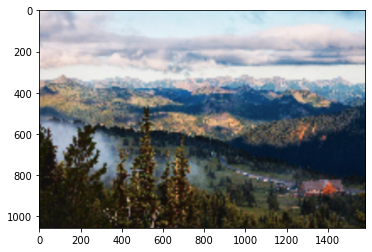

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

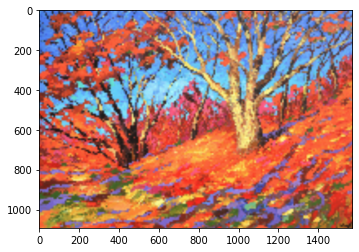

In [1]:
!pip install icecream
%matplotlib inline
import time
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from PIL import Image
from icecream import ic

import sys
sys.path.append("..") 
# import d2lzh_pytorch as d2l
from matplotlib import pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 均已测试

print(device, torch.__version__)
content_img = Image.open('/content/content_image1.png').convert('RGB')
# content_img = Image.open('/content/content_image1.png')
plt.imshow(content_img)
plt.show()
style_img = Image.open('/content/style_image1.png').convert('RGB')
# style_img = Image.open('/content/style_image1.png')
plt.imshow(style_img)
rgb_mean = np.array([0.485, 0.456, 0.406])
rgb_std = np.array([0.229, 0.224, 0.225])

def preprocess(PIL_img, image_shape):
    process = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    
    img_process = process(PIL_img)
    ic(img_process.shape)
    ic(img_process.unsqueeze(dim = 0).shape)

    return img_process.unsqueeze(dim = 0) # (batch_size, 3, H, W)

def postprocess(img_tensor):
    inv_normalize = torchvision.transforms.Normalize(
        mean= -rgb_mean / rgb_std,
        std= 1/rgb_std)
    ic(img_tensor[0].shape)
    to_PIL_image = torchvision.transforms.ToPILImage()
    return to_PIL_image(inv_normalize(img_tensor[0].cpu()).clamp(0, 1))
!echo $TORCH_HOME # 将会把预训练好的模型下载到此处(没有输出的话默认是.cache/torch)
pretrained_net = torchvision.models.vgg19(pretrained=True, progress=True)
pretrained_net


In [2]:
import os
if not os.path.exists('GeneratedImages/'):
  os.mkdir('GeneratedImages/')

In [3]:
import random
# loop = [0, 1, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]
# a=sorted(random.sample(loop, k=3))
# a

In [4]:
from itertools import combinations
# print(list(combinations([1,2,3,4,5], 3)))
# print(list(combinations([1,2,3,4,5], 3)))

In [ ]:
#选的内容图像在VGG中第几层，一个层
# loop = [0, 1]
loop = [0, 1, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]
len(loop)
loop_style = list(combinations(loop, 5))
# ic(loop_style)
ic(len(loop_style))
loop_style_random = random.sample(loop_style, k = 30)

start = time.time()

#plt画布大小
# plt.figure(figsize=(300*5, 450*5))
# plt.figure(figsize=(50, 50)) # in inches

for num, loop_i in enumerate(loop_style_random):
  # plt.subplot(5,5,num+1)
  style_layers, content_layers = list(loop_i), [25]

  #不加入不会用到的层
  net_list = []
  for i in range(max(content_layers + style_layers) + 1):
      net_list.append(pretrained_net.features[i])
  # 命名为net
  net = torch.nn.Sequential(*net_list)

  def extract_features(X, content_layers, style_layers):
      contents = []
      styles = []
      for i in range(len(net)):
          #每层的特征
          X = net[i](X)
          if i in style_layers: 
              #如果在style层列表里
              styles.append(X)
          if i in content_layers:
              #如果在content层列表里
              contents.append(X)
      return contents, styles

  def get_contents(image_shape, device):
      content_X = preprocess(content_img, image_shape).to(device)
      contents_Y, _ = extract_features(content_X, content_layers, style_layers)
      return content_X, contents_Y

  def get_styles(image_shape, device):
      style_X = preprocess(style_img, image_shape).to(device)
      _, styles_Y = extract_features(style_X, content_layers, style_layers)
      return style_X, styles_Y

  """## 9.11.5 定义损失函数
  ### 9.11.5.1 内容损失
  """

  def content_loss(Y_hat, Y):
      return F.mse_loss(Y_hat, Y)

  """### 9.11.5.2 样式损失"""

  def gram(X):
      num_channels, n = X.shape[1], X.shape[2] * X.shape[3]
      X = X.view(num_channels, n)
      return torch.matmul(X, X.t()) / (num_channels * n)

  def style_loss(Y_hat, gram_Y):
      return F.mse_loss(gram(Y_hat), gram_Y)

  """### 9.11.5.3 总变差损失"""

  def tv_loss(Y_hat):
      return 0.5 * (F.l1_loss(Y_hat[:, :, 1:, :], Y_hat[:, :, :-1, :]) + 
                    F.l1_loss(Y_hat[:, :, :, 1:], Y_hat[:, :, :, :-1]))

  """### 9.11.5.4 损失函数"""

  content_weight, style_weight, tv_weight = 1, 1e3, 10

  def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
      # 分别计算内容损失、样式损失和总变差损失
      contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
          contents_Y_hat, contents_Y)]
      styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
          styles_Y_hat, styles_Y_gram)]
      tv_l = tv_loss(X) * tv_weight
      # 对所有损失求和
      l = sum(styles_l) + sum(contents_l) + tv_l
      return contents_l, styles_l, tv_l, l

  """## 9.11.6 创建和初始化合成图像"""

  class GeneratedImage(torch.nn.Module):
      def __init__(self, img_shape):
          super(GeneratedImage, self).__init__()
          self.weight = torch.nn.Parameter(torch.rand(*img_shape))

      def forward(self):
          return self.weight

  def get_inits(X, device, lr, styles_Y):
      gen_img = GeneratedImage(X.shape).to(device)
      gen_img.weight.data = X.data
      optimizer = torch.optim.Adam(gen_img.parameters(), lr=lr)
      styles_Y_gram = [gram(Y) for Y in styles_Y]
      return gen_img(), styles_Y_gram, optimizer

  """## 9.11.7 训练"""

  # Commented out IPython magic to ensure Python compatibility.
  def train(X, contents_Y, styles_Y, device, lr, max_epochs, lr_decay_epoch):
      print("training on ", device)
      X, styles_Y_gram, optimizer = get_inits(X, device, lr, styles_Y)
      scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_decay_epoch, gamma=0.1)
      for i in range(max_epochs):
          start = time.time()
          
          contents_Y_hat, styles_Y_hat = extract_features(
                  X, content_layers, style_layers)
          contents_l, styles_l, tv_l, l = compute_loss(
                  X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
          
          optimizer.zero_grad()
          l.backward(retain_graph = True)
          optimizer.step()
          scheduler.step()
          
          if i % 50 == 0 and i != 0:
              print('epoch %3d, content loss %.2f, style loss %.2f, '
                    'TV loss %.2f, %.2f sec'
                     % (i, sum(contents_l).item(), sum(styles_l).item(), tv_l.item(),
                      time.time() - start))
      return X.detach()

  image_shape = (300, 450)
  net = net.to(device)
  content_X, contents_Y = get_contents(image_shape, device)
  style_X, styles_Y = get_styles(image_shape, device)
  big_output = train(content_X, contents_Y, styles_Y, device, 0.01, 500, 200)
  
  # d2l.set_figsize((7, 5))
  # d2l.plt.imshow(postprocess(big_output));
  
  plt.imshow(postprocess(big_output))
  # plt.xlabel()
  plt.savefig(f'GeneratedImages/style image layer {loop_i[0]} {loop_i[1]} {loop_i[2]} {loop_i[3]} {loop_i[4]}.png')

sec = time.time()-start
ic(f'Using gpu, {sec} s = {sec//60} m')

ic| len(loop_style): 4368
ic| img_process.shape: torch.Size([3, 300, 450])
ic| img_process.unsqueeze(dim = 0).shape: torch.Size([1, 3, 300, 450])
ic| img_process.shape: torch.Size([3, 300, 450])
ic| img_process.unsqueeze(dim = 0).shape: torch.Size([1, 3, 300, 450])


training on  cuda
epoch  50, content loss 0.03, style loss 0.20, TV loss 0.50, 1.11 sec
epoch 100, content loss 0.03, style loss 0.18, TV loss 0.42, 1.11 sec
epoch 150, content loss 0.04, style loss 0.17, TV loss 0.38, 1.11 sec
epoch 200, content loss 0.04, style loss 0.17, TV loss 0.35, 1.10 sec
epoch 250, content loss 0.04, style loss 0.17, TV loss 0.35, 1.11 sec
epoch 300, content loss 0.04, style loss 0.16, TV loss 0.34, 1.11 sec
epoch 350, content loss 0.04, style loss 0.16, TV loss 0.34, 1.10 sec
epoch 400, content loss 0.04, style loss 0.16, TV loss 0.34, 1.11 sec
epoch 450, content loss 0.04, style loss 0.16, TV loss 0.34, 1.10 sec


ic| img_tensor[0].shape: torch.Size([3, 300, 450])
ic| img_process.shape: torch.Size([3, 300, 450])
ic| img_process.unsqueeze(dim = 0).shape: torch.Size([1, 3, 300, 450])
ic| img_process.shape: torch.Size([3, 300, 450])
ic| img_process.unsqueeze(dim = 0).shape: torch.Size([1, 3, 300, 450])


training on  cuda
epoch  50, content loss 0.05, style loss 0.49, TV loss 0.62, 1.09 sec
epoch 100, content loss 0.06, style loss 0.34, TV loss 0.60, 1.09 sec
epoch 150, content loss 0.06, style loss 0.30, TV loss 0.58, 1.09 sec
epoch 200, content loss 0.06, style loss 0.27, TV loss 0.57, 1.09 sec
epoch 250, content loss 0.06, style loss 0.27, TV loss 0.56, 1.09 sec
epoch 300, content loss 0.06, style loss 0.27, TV loss 0.55, 1.09 sec
epoch 350, content loss 0.06, style loss 0.27, TV loss 0.55, 1.09 sec
epoch 400, content loss 0.06, style loss 0.27, TV loss 0.55, 1.08 sec
epoch 450, content loss 0.06, style loss 0.27, TV loss 0.55, 1.09 sec


ic| img_tensor[0].shape: torch.Size([3, 300, 450])
ic| img_process.shape: torch.Size([3, 300, 450])
ic| img_process.unsqueeze(dim = 0).shape: torch.Size([1, 3, 300, 450])
ic| img_process.shape: torch.Size([3, 300, 450])
ic| img_process.unsqueeze(dim = 0).shape: torch.Size([1, 3, 300, 450])


training on  cuda
epoch  50, content loss 0.02, style loss 0.29, TV loss 0.54, 1.07 sec
epoch 100, content loss 0.03, style loss 0.22, TV loss 0.49, 1.07 sec
epoch 150, content loss 0.03, style loss 0.19, TV loss 0.46, 1.07 sec
epoch 200, content loss 0.03, style loss 0.18, TV loss 0.44, 1.07 sec
epoch 250, content loss 0.03, style loss 0.18, TV loss 0.43, 1.06 sec
epoch 300, content loss 0.03, style loss 0.18, TV loss 0.43, 1.07 sec
epoch 350, content loss 0.03, style loss 0.18, TV loss 0.43, 1.07 sec
epoch 400, content loss 0.03, style loss 0.18, TV loss 0.43, 1.08 sec
epoch 450, content loss 0.03, style loss 0.18, TV loss 0.43, 1.07 sec


ic| img_tensor[0].shape: torch.Size([3, 300, 450])
ic| img_process.shape: torch.Size([3, 300, 450])
ic| img_process.unsqueeze(dim = 0).shape: torch.Size([1, 3, 300, 450])
ic| img_process.shape: torch.Size([3, 300, 450])
ic| img_process.unsqueeze(dim = 0).shape: torch.Size([1, 3, 300, 450])


training on  cuda
epoch  50, content loss 0.02, style loss 0.81, TV loss 0.69, 1.11 sec
epoch 100, content loss 0.03, style loss 0.69, TV loss 0.64, 1.11 sec
epoch 150, content loss 0.04, style loss 0.59, TV loss 0.63, 1.11 sec
epoch 200, content loss 0.05, style loss 0.52, TV loss 0.63, 1.11 sec
epoch 250, content loss 0.04, style loss 0.51, TV loss 0.63, 1.11 sec
epoch 300, content loss 0.04, style loss 0.50, TV loss 0.63, 1.11 sec
epoch 350, content loss 0.04, style loss 0.49, TV loss 0.63, 1.11 sec
epoch 400, content loss 0.04, style loss 0.49, TV loss 0.63, 1.11 sec
epoch 450, content loss 0.04, style loss 0.49, TV loss 0.63, 1.11 sec


ic| img_tensor[0].shape: torch.Size([3, 300, 450])
ic| img_process.shape: torch.Size([3, 300, 450])
ic| img_process.unsqueeze(dim = 0).shape: torch.Size([1, 3, 300, 450])
ic| img_process.shape: torch.Size([3, 300, 450])
ic| img_process.unsqueeze(dim = 0).shape: torch.Size([1, 3, 300, 450])


training on  cuda
epoch  50, content loss 0.09, style loss 0.89, TV loss 0.80, 1.13 sec
epoch 100, content loss 0.08, style loss 0.86, TV loss 0.69, 1.13 sec
epoch 150, content loss 0.08, style loss 0.84, TV loss 0.62, 1.13 sec
epoch 200, content loss 0.09, style loss 0.82, TV loss 0.58, 1.13 sec
epoch 250, content loss 0.08, style loss 0.82, TV loss 0.57, 1.13 sec
epoch 300, content loss 0.08, style loss 0.82, TV loss 0.57, 1.13 sec
epoch 350, content loss 0.08, style loss 0.82, TV loss 0.57, 1.13 sec


In [6]:
# plt.figure(figsize=(50, 50))
# plt.imshow(postprocess(big_output))

# # plt.show()

In [7]:
# !cp 'loop.png' /content/drive/MyDrive/QNN
